<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Parking_spot_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import cv2
import pickle
import shutil
import sklearn
import skimage
import zipfile
import IPython
import scipy.io
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import svm
import tensorflow_datasets
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import model_selection

#Image Classifier
At first we need to create a model to predict if a spot shown in the image is Empty or Occupied.

We use the [**parking lot dataset**](https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset) from kaggle for both classification and detection tasks.

###Data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d blanderbuss/parking-lot-dataset
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

In [ ]:
cls_data = './PKLot/PKLotSegmented'
train_path = './data/train'
val_path   = './data/validation'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

VAL_THRESHOLD = 0.2

In [ ]:
#since the models are big so we need to select only a portion of the data so the ram won't get fulled
limit = 80
data_arr = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)


data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

,path,label
0,./data/train/2013-01-20_14_25_10#005.jpg,0
1,./data/train/2013-01-20_10_50_06#015.jpg,0
2,./data/validation/2013-01-20_08_25_03#006.jpg,0
3,./data/train/2013-01-20_16_45_12#013.jpg,0
4,./data/train/2013-01-20_16_55_12#004.jpg,0
...,...,...
19981,./data/validation/2013-04-10_17_25_12#005.jpg,1
19982,./data/validation/2013-04-10_10_15_04#031.jpg,1
19983,./data/train/2013-04-10_07_50_02#007.jpg,1
19984,./data/validation/2013-04-10_08_15_02#012.jpg,1


In [ ]:
data.groupby(['label']).count()

,path
label,
0,10280
1,9706


In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory('./data',
                                                               validation_split=0.2,
                                                               subset='both',
                                                               seed=32,
                                                               image_size=(150, 150),
                                                               batch_size=32)

Found 5249 files belonging to 2 classes.
Using 4200 files for training.
Using 1049 files for validation.


### Visualization

In [ ]:
def show_images(ds, augmentation=False):
  plt.figure(figsize=(3, 3))
  for images, labels in ds.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          if augmentation:
            images = data_augmentation(images)
            i = 0
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(int(labels[i]))
          plt.axis("off")

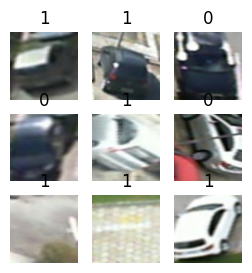

In [ ]:
show_images(train_ds)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
    ], name="img_augmentation")

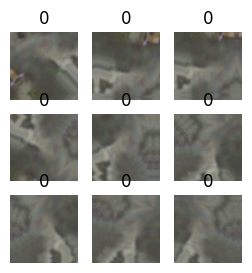

In [ ]:
show_images(train_ds, augmentation=True)

In [ ]:
augmented_train_ds = train_ds.map(lambda img, label : (data_augmentation(img), label),
                                  num_parallel_calls=tf.data.AUTOTUNE)

#(buffered) Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def plot_hist(hist, acc='binary_accuracy'):
    plt.plot(hist.history[f"{acc}"])
    plt.plot(hist.history[f"val_{acc}"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Model 1

A simple residual model with tensorflow

In [ ]:
def Model(input_shape, num_cls):
  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1/255)(inputs)
  x = layers = tf.keras.layers.Conv2D(128, 3, strides=3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  #Set Aside residual
  previous_block_activation = x

  for size in [256, 512, 728]:
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    residual = tf.keras.layers.Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)

    x = tf.keras.layers.add([x, residual])
    previous_block_activation = x

  x = tf.keras.layers.SeparableConv2D(1024, 3, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  if num_cls == 2:
    activation = 'sigmoid'
    units = 1
  else:
    activation = 'softmax'
    units = num_cls

  x  = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(units, activation=activation)(x)
  return tf.keras.Model(inputs, outputs)

In [ ]:
IMG_SIZE = 528
model = Model(input_shape=train_ds.take(1).element_spec[0].shape[1:], num_cls=2)
tf.keras.utils.plot_model(model, show_shapes=True)

### Model 2
An experiment with some of the top keras pre-trained classification models

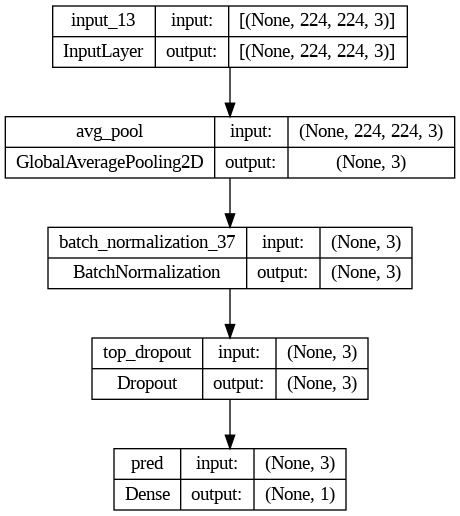

In [ ]:
# EfficientNetB6 input dim = 528
# EfficientNetB0 input dim = 224
# EfficientNetB3 input dim = 300
# VGG16 input dim = 224

epochs = 10
num_cls = 1
IMG_SIZE = 224
to_Dropout_rate = 0.2
callbacks = [tf.keras.callbacks.ModelCheckpoint('save_at_{epoch}.keras')]

inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
# x = inputs.copy()
x = data_augmentation(inputs)
model = tf.keras.applications.ResNet50V2(include_top=True, input_tensor=x, weights='imagenet')

model.trainable=False

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(model.input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(to_Dropout_rate, name='top_dropout')(x)
outputs = tf.keras.layers.Dense(num_cls, activation='softmax', name='pred')(x)

model = tf.keras.Model(inputs, outputs, name='model')
tf.keras.utils.plot_model(model, show_shapes=True)

### Model 3
An experiment with a sack of conv2d layers in keras to create a simple model to fit the data

In [ ]:
def Model(input_shape, num_cls=2):

  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1/255)(inputs)

  x = layers = tf.keras.layers.Conv2D(128, 3, strides=3, padding='same', activation='relu')(x)
  x = layers = tf.keras.layers.Conv2D(128, 3, strides=3, padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = layers = tf.keras.layers.Conv2D(64, 3, strides=3, padding='same', activation='relu')(x)
  x = layers = tf.keras.layers.Conv2D(64, 3, strides=3, padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = layers = tf.keras.layers.Conv2D(32, 3, strides=3, padding='same', activation='relu')(x)
  x = layers = tf.keras.layers.Conv2D(32, 3, strides=3, padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = layers = tf.keras.layers.Conv2D(16, 3, strides=3, padding='same', activation='relu')(x)
  x = layers = tf.keras.layers.Conv2D(16, 3, strides=3, padding='same', activation='relu')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)
  x  = tf.keras.layers.Dropout(0.5)(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  return tf.keras.Model(inputs, outputs)

In [ ]:
model = Model(input_shape=train_ds.take(1).element_spec[0].shape[1:], num_cls=2)
tf.keras.utils.plot_model(model, show_shapes=True)

###Compiling keras models

In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adamax(),
              loss = tf.keras.losses.BinaryCrossentropy(
              from_logits=False,
              label_smoothing=0.0,
              axis=-1,
              reduction="auto",
              name="binary_crossentropy"),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.AUC(
                                            num_thresholds=200,
                                            curve="ROC",
                                            summation_method="interpolation",
                                            name=None,
                                            dtype=None,
                                            thresholds=None,
                                            multi_label=False,
                                            num_labels=None,
                                            label_weights=None,
                                            from_logits=False),
                        tf.keras.metrics.Precision(thresholds=None, top_k=None, class_id=None, name=None, dtype=None)])

hist = model.fit(train_ds,
          epochs=10,
          callbacks=callbacks,
          validation_data=val_ds)

Epoch 1/10
56/56 [==============================] - 53s 843ms/step - loss: 0.7091 - binary_accuracy: 0.5278 - auc_5: 0.4884 - precision_5: 0.4175 - val_loss: 0.6895 - val_binary_accuracy: 0.5500 - val_auc_5: 0.4917 - val_precision_5: 0.4310
Epoch 2/10
56/56 [==============================] - 48s 850ms/step - loss: 0.6849 - binary_accuracy: 0.5545 - auc_5: 0.5139 - precision_5: 0.3924 - val_loss: 0.6819 - val_binary_accuracy: 0.5864 - val_auc_5: 0.4944 - val_precision_5: 0.0000e+00
Epoch 3/10
56/56 [==============================] - 46s 815ms/step - loss: 0.6785 - binary_accuracy: 0.5823 - auc_5: 0.5474 - precision_5: 0.4957 - val_loss: 0.6818 - val_binary_accuracy: 0.5864 - val_auc_5: 0.4876 - val_precision_5: 0.0000e+00
Epoch 4/10
56/56 [==============================] - 48s 853ms/step - loss: 0.6775 - binary_accuracy: 0.5789 - auc_5: 0.5471 - precision_5: 0.4815 - val_loss: 0.6827 - val_binary_accuracy: 0.5795 - val_auc_5: 0.5095 - val_precision_5: 0.0000e+00
Epoch 5/10
56/56 [======

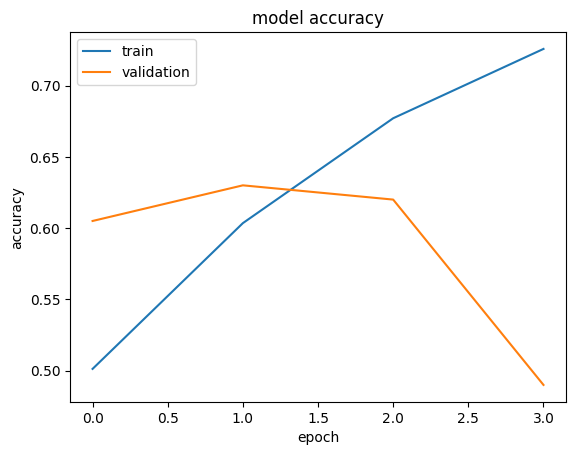

In [ ]:
plot_hist(hist)

### Model 4:
**Yolo V8**

Since the Yolo model needs some special data directory order, we need to change the data directory


In [ ]:
#install necessary libraries
!pip install awscli
!pip install ultralytics

import ultralytics
IPython.display.clear_output()

In [ ]:
cls_data = './PKLot/PKLotSegmented'
train_path_1 = './data/train/Empty/'
train_path_2 = './data/train/Occupied/'
val_path_1   = './data/validation/Empty/'
val_path_2   = './data/validation/Occupied/'

os.makedirs(train_path_1, exist_ok=True)
os.makedirs(val_path_1, exist_ok=True)
os.makedirs(train_path_2, exist_ok=True)
os.makedirs(val_path_2, exist_ok=True)

VAL_THRESHOLD = 0.2
data_arr = []
limit = 40


data = pd.DataFrame(data_arr, columns=['path', 'label'])
for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = 'train' if np.random.randn()<VAL_THRESHOLD else 'validation'
          target = os.path.join('./data', folder_name, E_O, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)
          break

data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

In [ ]:
# model = YOLO('yolov8n.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights
model = ultralytics.YOLO('yolov8n-cls.pt')
model.train(data='./data', epochs = 10, device='cpu', seed=32)

### model5
SVC model from sklearn since our data is so simple that CNN can't detect any patterns we can get a simpler model like SVC to handle this problem.

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

for path, label in data_arr:
  folder = path.split('/')[2]
  img = skimage.io.imread(path)
  img = skimage.transform.resize(img, (20, 20))

  if folder == 'validation':
    x_test.append(img.flatten())
    y_test.append(label)
  else:
    x_train.append(img.flatten())
    y_train.append(label)


x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(11584, 1200) (11584,)
(8402, 1200) (8402,)


In [ ]:
clf = svm.SVC()

parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

grid_search = model_selection.GridSearchCV(clf, parameters)

In [ ]:
grid_search.best_estimator_

SVC(C=10, gamma=0.01)

In [ ]:
grid_search.fit(x_train, y_train)

# test performance
best_estimator = grid_search.best_estimator_

y_prediction = best_estimator.predict(x_test)

score = metrics.accuracy_score(y_prediction, y_test)

print(f'{score * 100}% of samples were correctly classified')

pickle.dump(best_estimator, open('./drive/MyDrive/DATA/car_spot_model.p', 'wb'))

98.92882646988812% of samples were correctly classified


In [ ]:
test_data = []
test_label = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O):
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          test_data.append(path)
          test_label.append(label)


test = pd.DataFrame(test_data, columns=['path'])
test

,path
0,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
1,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
2,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
3,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
4,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
...,...
695846,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...
695847,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...
695848,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...
695849,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...


In [ ]:
scores = []
for path, label in zip(test_data, test_label):
  folder = path.split('/')[2]
  img = skimage.io.imread(path)
  img = skimage.transform.resize(img, (20, 20))
  img = np.asarray(img.flatten())
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  score = metrics.accuracy_score(pred, [label])
  scores.append(score)

In [ ]:
totall_score = np.sum(scores) / len(scores)
print(f'{totall_score * 100:.4f}% of samples were correctly classified, from {len(scores)}')
print(f'In totall, The model got {int(np.sum(scores))} / {len(scores)} Right answer')
print(f'In totall, The model got {len(scores) - int(np.sum(scores))} / {len(scores)} Wrong answer')

99.3211% of samples were correctly classified, from 695851
In totall, The model got 691127 / 695851 Right answer
In totall, The model got 4724 / 695851 Wrong answer


#Parking Spot Detector

In [ ]:
MODEL = pickle.load(open("./drive/MyDrive/DATA/model.p", "rb"))

In [ ]:
def empty_or_not(spot_bgr):

    img_resized = skimage.transform.resize(spot_bgr, (20, 20, 3))
    pred = MODEL.predict(np.array([img_resized.flatten()]))
    return True if pred == 0 else False

def get_parking_spots_bboxes(connected_components, coef=1):
    (totalLabels, label_ids, values, centroid) = connected_components

    slots = []
    for i in range(1, totalLabels):

        # Now extract the coordinate points
        x1 = int(values[i, cv2.CC_STAT_LEFT] * coef)
        y1 = int(values[i, cv2.CC_STAT_TOP] * coef)
        w = int(values[i, cv2.CC_STAT_WIDTH] * coef)
        h = int(values[i, cv2.CC_STAT_HEIGHT] * coef)

        slots.append([x1, y1, w, h])

    return slots

In [ ]:
calc_diff = lambda im1, im2: np.abs(np.mean(im1) - np.mean(im2))

In [ ]:
mask = './mask_1920_1080.png'
video_path = './samples/parking_1920_1080_loop.mp4'


mask = cv2.imread(mask, 0)

cap = cv2.VideoCapture(video_path)

connected_components = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)

spots = get_parking_spots_bboxes(connected_components)

spots_status = [None for j in spots]
diffs = [None for j in spots]

previous_frame = None

frame_nmr = 0
ret = True
step = 30
while ret:
    ret, frame = cap.read()

    if frame_nmr % step == 0 and previous_frame is not None:
        for spot_indx, spot in enumerate(spots):
            x1, y1, w, h = spot

            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]

            diffs[spot_indx] = calc_diff(spot_crop, previous_frame[y1:y1 + h, x1:x1 + w, :])

        print([diffs[j] for j in np.argsort(diffs)][::-1])

    if frame_nmr % step == 0:
        if previous_frame is None:
            arr_ = range(len(spots))
        else:
            arr_ = [j for j in np.argsort(diffs) if diffs[j] / np.amax(diffs) > 0.4]
        for spot_indx in arr_:
            spot = spots[spot_indx]
            x1, y1, w, h = spot

            spot_crop = frame[y1:y1 + h, x1:x1 + w, :]

            spot_status = empty_or_not(spot_crop)

            spots_status[spot_indx] = spot_status

    if frame_nmr % step == 0:
        previous_frame = frame.copy()

    for spot_indx, spot in enumerate(spots):
        spot_status = spots_status[spot_indx]
        x1, y1, w, h = spots[spot_indx]

        if spot_status:
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 255, 0), 2)
        else:
            frame = cv2.rectangle(frame, (x1, y1), (x1 + w, y1 + h), (0, 0, 255), 2)

    cv2.rectangle(frame, (80, 20), (550, 80), (0, 0, 0), -1)
    cv2.putText(frame, f'Available spots: {sum(spots_status)} / {len(spots_status)}', (100, 60),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
    cv2.imshow('frame', frame)
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    frame_nmr += 1

cap.release()
cv2.destroyAllWindows()

In [ ]:
img = tf.keras.utils.load_img('./dfdf.jpg', target_size=(IMG_SIZE, IMG_SIZE, 3))
plt.imshow(img)

img_arr = tf.keras.utils.img_to_array(img)
img_arr = tf.expand_dims(img_arr, 0) # Create batch axis

pred = model.predict(img_arr)
score = float(pred[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")


#Unfreeze some layers
for layer in model.layers[-20:]:
  if not isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = True

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds, verbose=2)
plot_hist(hist)

#Parking Spot Detector 2

In [2]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
tf.keras.utils.get_file(filename, url)

with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")

560525318/560525318 [==============================] - 6s 0us/step


In [ ]:
def convert_to_corners(boxes):
    return tf.concat([boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],axis=-1,)

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = f"{_cls}: {score:.2f}"
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle([x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth)
        ax.add_patch(patch)
        ax.text(x1, y1, text, bbox={"facecolor": color, "alpha": 0.4},clip_box=ax.clipbox, clip_on=True,)
    plt.show()
    return ax

In [ ]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1])
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4])

    def get_anchors(self, image_height, image_width):
        anchors = [self._get_anchors(tf.math.ceil(image_height / 2 ** i), tf.math.ceil(image_width / 2 ** i), i,) for i in range(3, 8)]
        return tf.concat(anchors, axis=0)

In [ ]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack([1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1)
    return image, boxes


def resize_and_pad_image(image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0):
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32)
    image = tf.image.pad_to_bounding_box(image, 0, 0, padded_image_shape[0], padded_image_shape[1])
    return image, image_shape, ratio

def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

def convert_to_xywh(boxes):
    return tf.concat([(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],axis=-1,)

def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [ ]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)

    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return ( matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),)

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat([(matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),], axis=-1,)
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(anchor_boxes, gt_boxes)
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids)
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [ ]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(include_top=False, input_shape=[None, None, 3])
    c3_output, c4_output, c5_output = [backbone.get_layer(layer_name).output for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]]
    return tf.keras.Model(inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output])

class FeaturePyramid(tf.keras.layers.Layer):
    def __init__(self, backbone=None, **kwargs):
        super().__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [ ]:
def build_head(output_filters, bias_init):

    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init))
        head.add(tf.keras.layers.ReLU())

    head.add(tf.keras.layers.Conv2D(output_filters, 3,1, padding="same", kernel_initializer=kernel_init, bias_initializer=bias_init,))
    return head

class RetinaNet(tf.keras.Model):
    def __init__(self, num_classes, backbone=None, **kwargs):
        super().__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(tf.reshape(self.cls_head(feature), [N, -1, self.num_classes]))
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

class DecodePredictions(tf.keras.layers.Layer):
    def __init__(self, num_classes=80, confidence_threshold=0.05, nms_iou_threshold=0.5, max_detections_per_class=100, max_detections=100, box_variance=[0.1, 0.1, 0.2, 0.2], **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor([0.1, 0.1, 0.2, 0.2], dtype=tf.float32)

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],],axis=-1,)
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,)


class RetinaNetBoxLoss(tf.losses.Loss):
    def __init__(self, delta):
        super().__init__(reduction="none", name="RetinaNetBoxLoss")
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    def __init__(self, alpha, gamma):
        super().__init__(reduction="none", name="RetinaNetClassificationLoss")
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super().__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(tf.cast(y_true[:, :, 4], dtype=tf.int32), depth=self._num_classes, dtype=tf.float32,)
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

In [ ]:
batch_size = 2
label_encoder = LabelEncoder()

#  set `data_dir=None` to load the complete dataset
(train_dataset, val_dataset), dataset_info = tensorflow_datasets.load("coco/2017", split=["train", "validation"], with_info=True, data_dir="data")

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True)

train_dataset = train_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.Dataset.ignore_errors)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True)

val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.Dataset.ignore_errors)
val_dataset = val_dataset.prefetch(autotune)

In [ ]:
(train, val), ds_info = tensorflow_datasets.load("coco/2017", split=["train", "validation"], with_info=True, data_dir="data")

# train = train.map(preprocess_data, num_parallel_calls=autotune)
# train = train.shuffle(8 * batch_size)
# train = train.padded_batch(batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True)
# train.take(1)
images = train.take(1)
# images[0].numpy().astype("uint8")
# tensorflow_datasets.visualization.show_examples(train, ds_info, is_batched=True)

In [ ]:
num_classes = 80

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [ ]:
# Uncomment the following lines, when training on full dataset
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 1

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset
model_dir = "retinanet/"
callbacks_list = [tf.keras.callbacks.ModelCheckpoint(filepath=f'{model_dir}'+'weights_epoch_{epoch}', monitor="loss", save_best_only=False, save_weights_only=True, verbose=1)]

model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(5),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

In [ ]:
# Change this to `model_dir` when not using the downloaded weights
weights_dir = "data"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio


val_dataset = tensorflow_datasets.load("coco/2017", split="validation", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

for sample in val_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

#Parking Spot Detector 3

In [7]:
download_file_path = tf.keras.utils.get_file(fname='caltech_101_zipped',
                        origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
                        extract=True,
                        archive_format='zip',
                        cache_dir='./')

download_file_path

137414764/137414764 [==============================] - 8s 0us/step


'./datasets/caltech_101_zipped'

In [17]:
shutil.unpack_archive("./datasets/caltech-101/101_ObjectCategories.tar.gz", "./")
shutil.unpack_archive("./datasets/caltech-101/Annotations.tar", "./")

img_path = './101_ObjectCategories/airplanes/'
ann_path = './Annotations/Airplanes_Side_2/'

image_paths = [img_path+p for p in os.listdir(img_path) if os.path.isfile(img_path+p)]
annot_paths = [ann_path+p for p in os.listdir(ann_path) if os.path.isfile(ann_path+p)]

image_paths.sort()
annot_paths.sort()

len(image_paths), len(annot_paths)

(800, 800)

In [63]:
IMG_SIZE = 224
PATCH_SIZE = 32

batch_size = 32
num_epochs = 100
projection_dim = 64

config = {"img_size": IMG_SIZE,
        "input_shape": (IMG_SIZE, IMG_SIZE, 3),
        "patch_size": PATCH_SIZE,
        "num_patches": (IMG_SIZE // PATCH_SIZE) ** 2,
        "projection_dim": projection_dim,
        "num_heads": 4,
        "transformer_units": [projection_dim * 2, projection_dim],
        "transformer_layers": 4,
        "mlp_head_units": [2048, 1024, 512, 64, 32], # Size of the dense layers
        "num_epochs": num_epochs,
        "batch_size": batch_size,
        "learning_rate": 0.001,
        "weight_decay": 0.0001
    }

In [64]:
x_train, y_train, x_test, y_test = [], [], [], []

for img_path, annot_path in zip(image_paths, annot_paths):
  annotate = scipy.io.loadmat(annot_path)['box_coord'][0]
  image    = tf.keras.utils.load_img(img_path)
  width, height = image.size[:2]
  top_left_x, top_left_y, bottom_right_x, bottom_right_y = annotate[2]/width, annotate[0]/height, annotate[3]/width, annotate[1]/height

  if np.random.randn() < 0.8: #Train
    image = image.resize((IMG_SIZE, IMG_SIZE))
    x_train.append(tf.keras.utils.img_to_array(image))
    y_train.append((top_left_x, top_left_y, bottom_right_x, bottom_right_y))
  else: #Test
    x_test.append(tf.keras.utils.img_to_array(image))
    y_test.append((top_left_x, top_left_y, bottom_right_x, bottom_right_y))

x_train, y_train, x_test, y_test = np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test)

<ipython-input-64-6deb7bf30ec7>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train, x_test, y_test = np.asarray(x_train), np.asarray(y_train), np.asarray(x_test), np.asarray(y_test)


In [65]:
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
      super().__init__()
      self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        sizes = strides = [1, self.patch_size, self.patch_size, 1]
        patches = tf.image.extract_patches(images=images, sizes=sizes, strides=strides, rates=[1, 1, 1, 1],padding="VALID")
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

In [66]:
class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection = tf.keras.Dense(units=projection_dim)
    self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches,
                                                        output_dim=projection_dim)
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches)
    encoded  = self.projection(patch) + self.position_embedding(positions)
    return encoded

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


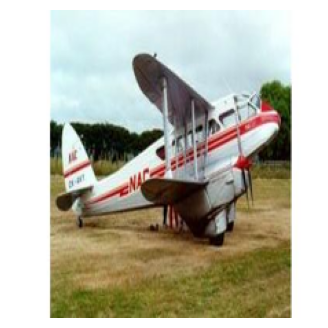

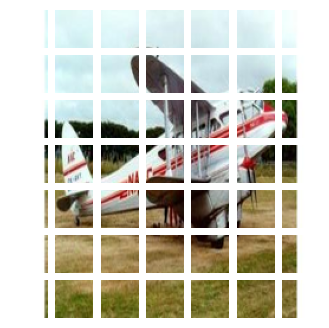

In [67]:
Sample = x_train[np.random.randint(len(x_train))]
plt.figure(figsize=(4, 4))
plt.imshow(Sample.astype("uint8"))
plt.axis("off")

patches = Patches(PATCH_SIZE)(tf.convert_to_tensor([Sample]))
print(f"Image size: {IMG_SIZE} X {IMG_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (PATCH_SIZE, PATCH_SIZE, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [61]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = tf.keras.layers.Dense(units, activation=tf.keras.activations.gelu)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def vit_object_decetor(config):
  input_shape = config['input_shape']
  patch_size = config['patch_size']
  num_patches = config['num_patches']
  projection_dim = config['projection_dim']
  num_heads = config['num_heads']
  transformer_units = config['transformer_units']
  transformer_layers = config['transformer_layers']
  mlp_head_units = config['mlp_head_units']

  inputs = tf.keras.layers.Input(shape=input_shape)
  patches = Patches(patch_size)

